In [226]:
%matplotlib widget

In [2]:
# Plot error space for one example of case A.2

# Import libraries
import numpy as np
import pygimli as pg
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn.metrics import root_mean_squared_error
from mpl_toolkits import mplot3d
import sys
sys.path.insert(1, '../../src')

# Import functions
from EM1D import EMf_3Lay_HVP, GlobalSearch_3Lay, EMf_3Lay_Opt_HVP_1D

In [40]:
# Load model and data
model_B1_1 = np.load('models/model_synth_B1_1.npy')
model_B1_2 = np.load('models/model_synth_B1_2.npy')
model_B1_3 = np.load('models/model_synth_B1_3.npy')
model_B1_4 = np.load('models/model_synth_B1_4.npy')

data_B1_1 = np.load('data/data_synth_B1_1.npy')
data_B1_2 = np.load('data/data_synth_B1_2.npy')
data_B1_3 = np.load('data/data_synth_B1_3.npy')
data_B1_4 = np.load('data/data_synth_B1_4.npy')

data_B1_1_GS = np.load('data/data_GS_B1_1.npy')

#LUT = np.load('../data/LUTable_3Lay.npy')
conds = np.load('../data/conds.npy')
thicks = np.load('../data/thicks.npy')

# Load survey parameters
survey = np.load('../data/survey_3Lay.npy', allow_pickle=True).item()
offsets = survey['offsets']
height = survey['height']
freq = survey['freq']
lambd = survey['lambd']
filt = survey['filt']

# Load estimated model from Global Search
model_GS_B1_1 = np.load('results/model_GS_B1_1.npy')
model_GS_B1_2 = np.load('results/model_GS_B1_2.npy')
model_GS_B1_3 = np.load('results/model_GS_B1_3.npy')
model_GS_B1_4 = np.load('results/model_GS_B1_4.npy')

# Load estimated models from Optimization
model_Opt_B1_1 = np.load('results/model_Opt_B1_1.npy')
model_Opt_B1_2 = np.load('results/model_Opt_B1_2.npy')
model_Opt_B1_3 = np.load('results/model_Opt_B1_3.npy')
model_Opt_B1_4 = np.load('results/model_Opt_B1_4.npy')

# For example let's check the 1D model following position
pos = 10
nsl = len(conds)

In [41]:
def NoiseAnalysis_GS_2Lay(data_true, noise=0.1, test_it=100):
    
    models_GS = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        models_GS.append(GlobalSearch_2Lay(LUT, data_noise, conds, thicks, nsl))
    return models_GS 

def NoiseAnalysis_Opt_3Lay(data_true, noise=0.1, test_it=100):
    m0 = [3, 3, 100/1000, 100/1000, 100/1000]
    lam = 0
    models_Opt = []
    
    transThk = pg.trans.TransLogLU(1,4)
    transSig = pg.trans.TransLogLU(10/1000,2000/1000)
    
    for i in range(test_it):
        EMf = EMf_3Lay_Opt_HVP_1D(lambd, height, offsets, freq, filt, nlay=3)
        
        # Define transformation
        EMf.region(0).setTransModel(transThk)
        EMf.region(1).setTransModel(transSig)

        # Define inversion framework from pygimli
        invEM = pg.Inversion()
        invEM.setForwardOperator(EMf) # set forward operator

        # Relative error array
        error = 1e-3 # relative error
        relativeError = np.ones_like(data_true[0]) * error
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        models_Opt.append(invEM.run(data_noise, relativeError, startModel= m0, lam=lam, verbose=False))
    return models_Opt


In [46]:
def m0_Analysis_Opt_3Lay(sigma, data_true):
    m0 = [3, 3, sigma/1000, sigma/1000, sigma/1000]
    lam = 0
    models_Opt = []
    
    transThk = pg.trans.TransLogLU(1,4)
    transSig = pg.trans.TransLogLU(10/1000,2000/1000)
    
    EMf = EMf_3Lay_Opt_HVP_1D(lambd, height, offsets, freq, filt, nlay=3)

    # Define transformation
    EMf.region(0).setTransModel(transThk)
    EMf.region(1).setTransModel(transSig)

    # Define inversion framework from pygimli
    invEM = pg.Inversion()
    invEM.setForwardOperator(EMf) # set forward operator

    # Relative error array
    error = 1e-3 # relative error
    relativeError = np.ones_like(data_true[0]) * error
    model_Opt = invEM.run(data_true, relativeError, startModel= m0, lam=lam, verbose=False)
    return model_Opt

In [47]:
sigmas = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

In [110]:
models_m0_B1_1 = []
models_m0_B1_2 = []
models_m0_B1_3 = []
models_m0_B1_4 = []

for sigma in sigmas:
    models_m0_B1_1.append(m0_Analysis_Opt_3Lay(sigma, data_B1_1[pos]))
    models_m0_B1_2.append(m0_Analysis_Opt_3Lay(sigma, data_B1_2[pos]))
    models_m0_B1_3.append(m0_Analysis_Opt_3Lay(sigma, data_B1_3[pos]))
    models_m0_B1_4.append(m0_Analysis_Opt_3Lay(sigma, data_B1_4[pos]))
    
models_m0_B1_1 = np.array(models_m0_B1_1)
models_m0_B1_2 = np.array(models_m0_B1_2)
models_m0_B1_3 = np.array(models_m0_B1_3)
models_m0_B1_4 = np.array(models_m0_B1_4)

In [123]:
# Plot

def PlotModel(model, depths, ax=None, model_name=None, model_style='k', ylab=False, xlab=False, lw=1):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    ax.step(model, depths, color=model_style, label=model_name, linewidth=lw)
    ax.set_xscale('log')
    if xlab == True:
        ax.set_xlabel('Electrical conductivity [mS/m]', fontsize=fs)
    if ylab == True:
        ax.set_ylabel('Depth [m]', fontsize=fs)
    if model_name is not None:
        ax.legend(fontsize=fs, bbox_to_anchor=(1.1, 1.05))
    ax.tick_params(labelsize=fs)
    plt.tight_layout()

    
def Plot_m0(models_m0, model_true, dmax=-10, ax=None, ylab=False, xlab=False, legend=False):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    
    for m in range(len(models_m0)):
        color = (0.1*m, 0.5, 0.1)
        mod = models_m0[m]
        sigma_2Lay_plot = np.hstack((mod[2:], mod[-1]))
        depths_2Lay_plot = np.hstack([0, -mod[0], -np.sum(mod[:2]), dmax])
        if legend == True:
            PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style=color, model_name='$m_0: $' + str(sigmas[m]) + ' mS/m')
        else:
            PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style=color, )
    sigma_true = np.hstack((model_true[2:], model_true[-1]))
    depth_true = np.hstack([0, -model_true[0], -np.sum(model_true[:2]), dmax])
    if legend == True:
        PlotModel(sigma_true, depth_true, model_name='True', ax=ax, lw = 2)
    else:
        PlotModel(sigma_true, depth_true, ax=ax, lw=2)
    
 #   sigma_est = np.hstack((model_est[1:], model_est[-1]))
 #   depth_est = np.array([0, -model_est[0], dmax])
 #   PlotModel(sigma_est, depth_est, model_name='Est', ax=ax, model_style='r', ylab=ylab, xlab=xlab)

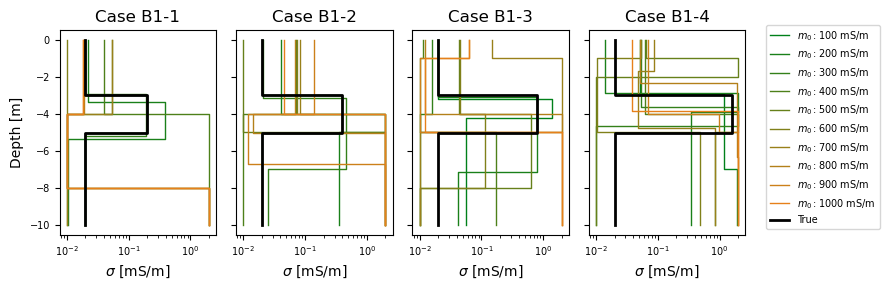

In [127]:
fig, ax = plt.subplots(1,4, figsize=(9,3), sharey=True)

Plot_m0(models_m0_B1_1, model_B1_1[pos], ax=ax[0])
Plot_m0(models_m0_B1_2, model_B1_2[pos], ax=ax[1])
Plot_m0(models_m0_B1_3, model_B1_3[pos], ax=ax[2])
Plot_m0(models_m0_B1_4, model_B1_4[pos], ax=ax[3], legend=True)
ax[0].set_title('Case B1-1')
ax[1].set_title('Case B1-2')
ax[2].set_title('Case B1-3')
ax[3].set_title('Case B1-4')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('$\sigma$ [mS/m]')
ax[1].set_xlabel('$\sigma$ [mS/m]')
ax[2].set_xlabel('$\sigma$ [mS/m]')
ax[3].set_xlabel('$\sigma$ [mS/m]')
plt.tight_layout()

In [263]:
def nrmse(obs, pred):
    
    nrse = root_mean_squared_error(obs, pred)/np.abs(np.max(obs)-np.min(obs))
    return nrse

def Error_analysis_h2_s2_s3(model_est, model_true, data_true, pos, thicks, conds, max_err=0.1):
    """ change later rmse"""
    err = []
    models_err = []
    for h2 in thicks:
        for sigma2 in conds:
            for sigma3 in conds:
                mod = [model_true[pos,0], h2, model_true[pos,2], sigma2, sigma3]
                h1 = model_true[pos,0]
                sigma1 = model_true[pos,2]
              #  sigma3 = model_true[pos,4]
                dat = EMf_3Lay_HVP(lambd, sigma1, sigma2, sigma3, h1, h2, height, offsets, freq, filt)
                nrse = nrmse(data_true[pos], dat)

                if nrse < max_err:
                    err.append(nrse)    
                    models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err

In [270]:
err_GS_B1_1, models_err_GS_B1_1 = Error_analysis_h2_s2_s3(model_GS_B1_1, model_B1_1, data_B1_1, pos, thicks, conds, max_err=0.05)
#err_GS_B1_2, models_err_GS_B1_2 = Error_analysis_h2_s2_s3(model_GS_B1_2, model_B1_2, data_B1_2, pos, thicks, conds)
#err_GS_B1_3, models_err_GS_B1_3 = Error_analysis_h2_s2(model_GS_B1_3, model_B1_3, data_B1_3, pos, thicks, conds)
#err_GS_B1_4, models_err_GS_B1_4 = Error_analysis_h2_s2(model_GS_B1_4, model_B1_4, data_B1_4, pos, thicks, conds)

In [265]:
def PlotErrorSpace(ax1, ax2, model, model_est, model_opt, err, models_err, xmin, xmax, ymin, ymax, case='', method='', depthmax=-8, colorbar=False):
    # Arrays to plot
    depth_true = np.array([0, -model[0], -np.sum(model[:2]), depthmax])
    depth_est = np.array([0, -model_est[0], -np.sum(model_est[:2]), depthmax])
    depth_opt = np.array([0, -model_opt[0], -np.sum(model_opt[:2]), depthmax])

    sigma_true = np.hstack([model[2:], model[-1]])
    sigma_est = np.hstack([model_est[2:], model_est[-1]])
    sigma_opt = np.hstack([model_opt[2:], model_opt[-1]])
       
  #  fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax1.step(sigma_true*1000, depth_true, 'k', label = 'True')
    ax1.step(sigma_est*1000, depth_est, 'g', label='GS')
    ax1.step(sigma_opt*1000, depth_opt, 'r', label='Opt')
    ax1.set_xlim([10,2000])
    ax1.set_ylabel('Depth [m]', fontsize=8)
    ax1.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax1.set_title('1D Model position: ' +str(pos) + ' - Case: '+case, fontsize=8)
    ax1.set_xscale('log')
    ax1.legend(fontsize=7)

    x = ((models_err[:,3])*1000) # conductivities of first layer in mS/m
    y = models_err[:,1]          # thickness of first layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax2.contour(xi, yi, zi*100, levels=15, linewidths=0.5, colors='k', )
    cntr1 = ax2.contourf(xi, yi, zi*100, levels=15, cmap="RdBu_r", vmin=0.1, vmax=10)
    ax2.plot(x, y, '.k', ms=1)
    ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax2.scatter(model[3]*1000, model[1], marker='o', c='k', label='True model',)
    ax2.scatter(((model_est[3])*1000), model_est[1], marker ='x', c='y', label='GS', )
    ax2.scatter(((model_opt[3])*1000), model_opt[1], marker ='x', c='c', label='GS', )
    ax2.set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
    ax2.set_ylabel('$h_1$ [m]', fontsize=8)
    ax2.legend(fontsize=7)
    ax2.tick_params(axis='both',labelsize=9)
    ax1.tick_params(axis='both',labelsize=9)
    ax2.set_title(method, fontsize=8)
    
    if colorbar==True:
        clb = fig.colorbar(cntr1, ax=ax2, ticks=[0, 2.5,5,7.5,10])
        clb.ax.set_title('NRMSE %', fontsize=7)
        clb.ax.tick_params(labelsize=9)



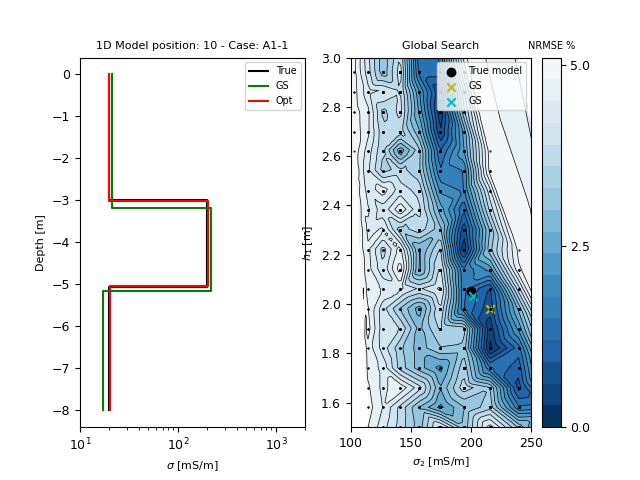

In [266]:
fig, ax = plt.subplots(1,2)

PlotErrorSpace(ax[0], ax[1], model_B1_1[pos], model_GS_B1_1[pos], model_Opt_B1_1[pos], err_GS_B1_1, models_err_GS_B1_1, 100, 250, 1.5, 3, 
               case='A1-1', method='Global Search', colorbar=True)

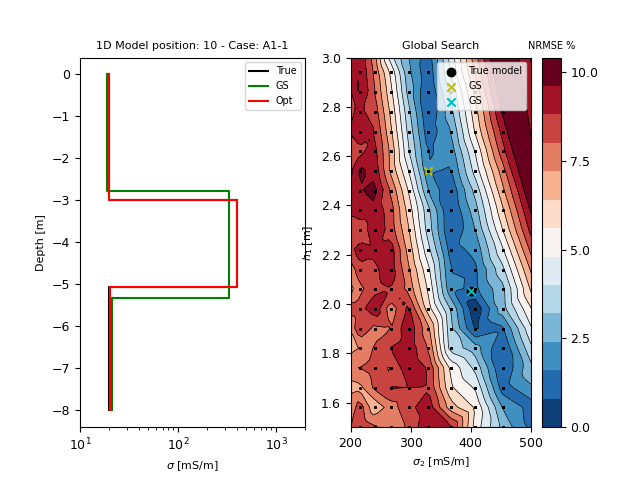

In [259]:
fig, ax = plt.subplots(1,2)

PlotErrorSpace(ax[0], ax[1], model_B1_2[pos], model_GS_B1_2[pos], model_Opt_B1_2[pos], err_GS_B1_2, models_err_GS_B1_2, 200, 500, 1.5, 3, 
               case='A1-1', method='Global Search', colorbar=True)

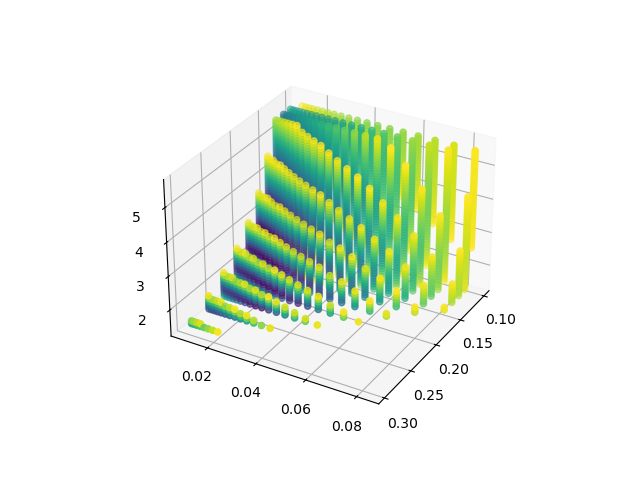

In [267]:

fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining axes
z = models_err_GS_B1_1[:,1] # h2
x = models_err_GS_B1_1[:,3] # s1
y = models_err_GS_B1_1[:,4] # s2
c = err_GS_B1_1
ax.scatter(x, y, z, c = c)
ax.scatter(model_GS_B1_1[pos,3], model_GS_B1_1[pos,4], model_GS_B1_1[pos,1], c='r')
ax.view_init(30, 30,0)
# syntax for plotting
#ax.set_title('3d Scatter plot geeks for geeks')
plt.show()

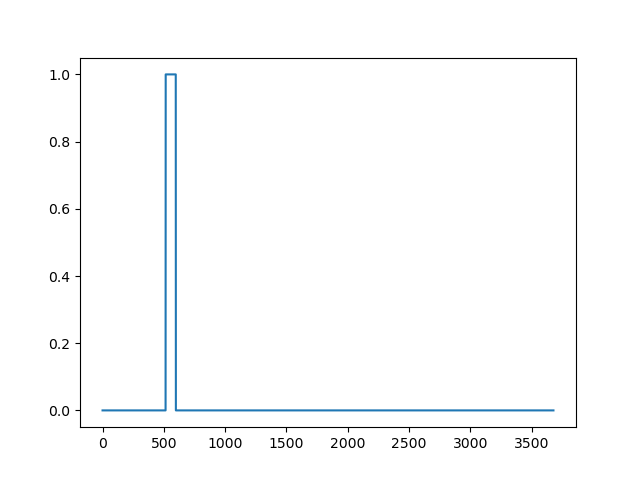

In [274]:
plt.figure()
plt.plot(models_err_GS_B1_1[:,1] == model_GS_B1_1[pos,1])

In [ ]:
np.save('results/models_noise_GS_A1_1',models_noise_GS_A1_1)
np.save('results/models_noise_GS_A1_2',models_noise_GS_A1_2)
np.save('results/models_noise_GS_A1_3',models_noise_GS_A1_3)
np.save('results/models_noise_GS_A1_4',models_noise_GS_A1_4)

np.save('results/models_noise_Opt_A1_1', models_noise_Opt_A1_1)
np.save('results/models_noise_Opt_A1_2', models_noise_Opt_A1_2)
np.save('results/models_noise_Opt_A1_3', models_noise_Opt_A1_3)
np.save('results/models_noise_Opt_A1_4', models_noise_Opt_A1_4)

In [5]:
# Load
models_noise_GS_A1_1 = np.load('results/models_noise_GS_A1_1.npy')
models_noise_GS_A1_2 = np.load('results/models_noise_GS_A1_2.npy')
models_noise_GS_A1_3 = np.load('results/models_noise_GS_A1_3.npy')
models_noise_GS_A1_4 = np.load('results/models_noise_GS_A1_4.npy')

models_noise_Opt_A1_1 = np.load('results/models_noise_Opt_A1_1.npy')
models_noise_Opt_A1_2 = np.load('results/models_noise_Opt_A1_2.npy')
models_noise_Opt_A1_3 = np.load('results/models_noise_Opt_A1_3.npy')
models_noise_Opt_A1_4 = np.load('results/models_noise_Opt_A1_4.npy')

In [7]:

def Plot_Noise(models_noise, model_true, model_est, dmax=-8, ax=None, ylab=False, xlab=False):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    for m in range(len(models_noise)):
        mod = models_noise[m]
        sigma_2Lay_plot = np.hstack((mod[1:], mod[-1]))
        depths_2Lay_plot = np.array([0, -mod[0], dmax])
        PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style='paleturquoise')
    
    sigma_true = np.hstack((model_true[1:], model_true[-1]))
    depth_true = np.array([0, -model_true[0], dmax])
    PlotModel(sigma_true, depth_true, model_name='True', ax=ax,)
    
    sigma_est = np.hstack((model_est[1:], model_est[-1]))
    depth_est = np.array([0, -model_est[0], dmax])
    PlotModel(sigma_est, depth_est, model_name='Est', ax=ax, model_style='r', ylab=ylab, xlab=xlab)



15/05/24 - 13:33:45 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


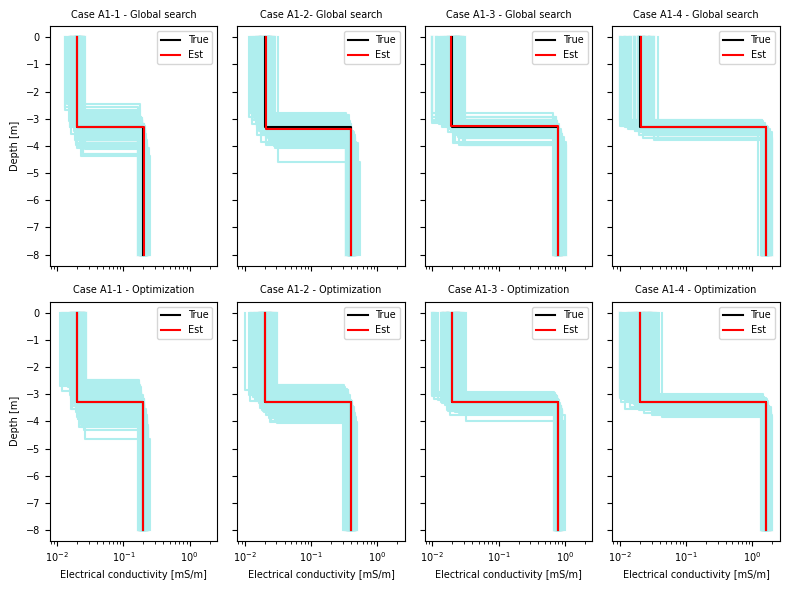

In [8]:
fig, ax = plt.subplots(2,4, sharex=True, sharey=True, figsize=(8,6))
fs=7

Plot_Noise(models_noise_GS_A1_1, model_A1_1[pos], model_GS_A1_1[pos], ax=ax[0,0], ylab=True)
ax[0,0].set_title('Case A1-1 - Global search', fontsize=fs)
Plot_Noise(models_noise_GS_A1_2, model_A1_2[pos], model_GS_A1_2[pos], ax=ax[0,1])
ax[0,1].set_title('Case A1-2- Global search', fontsize=fs)
Plot_Noise(models_noise_GS_A1_3, model_A1_3[pos], model_GS_A1_3[pos], ax=ax[0,2])
ax[0,2].set_title('Case A1-3 - Global search', fontsize=fs)
Plot_Noise(models_noise_GS_A1_4, model_A1_4[pos], model_GS_A1_4[pos], ax=ax[0,3])
ax[0,3].set_title('Case A1-4 - Global search', fontsize=fs)

Plot_Noise(models_noise_Opt_A1_1, model_A1_1[pos], model_Opt_A1_1[pos], ax=ax[1,0], ylab=True, xlab=True)
ax[1,0].set_title('Case A1-1 - Optimization', fontsize=fs)
Plot_Noise(models_noise_Opt_A1_2, model_A1_2[pos], model_Opt_A1_2[pos], ax=ax[1,1], xlab=True)
ax[1,1].set_title('Case A1-2 - Optimization', fontsize=fs)
Plot_Noise(models_noise_Opt_A1_3, model_A1_3[pos], model_Opt_A1_3[pos], ax=ax[1,2], xlab=True)
ax[1,2].set_title('Case A1-3 - Optimization', fontsize=fs)
Plot_Noise(models_noise_Opt_A1_4, model_A1_4[pos], model_Opt_A1_4[pos], ax=ax[1,3], xlab=True)
ax[1,3].set_title('Case A1-4 - Optimization', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/NoiseAnalysis_CaseA1.eps', format='eps')

In [16]:
def nrmse(obs, pred):
    
    nrse = root_mean_squared_error(obs, pred)/np.abs(np.max(obs)-np.min(obs))
    return nrse

In [19]:
def Error_analysis_sigma1(model_est, data_true, pos, thicks, conds):
    """ change later rmse"""
    err = []
    models_err = []
    for h1 in thicks:
        for sigma2 in conds:
            mod = [h1, model_est[pos,1], sigma2]
            sigma1 = model_est[pos,1]
            dat = EMf_2Lay_HVP(lambd, sigma1, sigma2, h1, height, offsets, freq, filt)
            nrse = nrmse(data_true[pos], dat)
            
            if nrse < 0.1:
                err.append(nrse)    
                models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err

In [42]:
err_GS_A1_1, models_err_GS_A1_1 = Error_analysis_sigma1(model_GS_A1_1, data_A1_1, pos, thicks, conds)
err_GS_A1_2, models_err_GS_A1_2 = Error_analysis_sigma1(model_GS_A1_2, data_A1_2, pos, thicks, conds)
err_GS_A1_3, models_err_GS_A1_3 = Error_analysis_sigma1(model_GS_A1_3, data_A1_3, pos, thicks, conds)
err_GS_A1_4, models_err_GS_A1_4 = Error_analysis_sigma1(model_GS_A1_4, data_A1_4, pos, thicks, conds)

err_Opt_A1_1, models_err_Opt_A1_1 = Error_analysis_sigma1(model_Opt_A1_1, data_A1_1, pos, thicks, conds)
err_Opt_A1_2, models_err_Opt_A1_2 = Error_analysis_sigma1(model_Opt_A1_2, data_A1_2, pos, thicks, conds)
err_Opt_A1_3, models_err_Opt_A1_3 = Error_analysis_sigma1(model_Opt_A1_3, data_A1_3, pos, thicks, conds)
err_Opt_A1_4, models_err_Opt_A1_4 = Error_analysis_sigma1(model_Opt_A1_4, data_A1_4, pos, thicks, conds)

In [131]:
# Function to plot Error space

def PlotErrorSpace(ax1, ax2, model, model_est, err, models_err, xmin, xmax, ymin, ymax, case='', method='', depthmax=-8, colorbar=False):
    # Arrays to plot
    depth_true = np.array([0, -model[0], depthmax])
    depth_est = np.array([0, -model_est[0], depthmax])

    sigma_true = np.hstack([model[1:], model[-1]])
    sigma_est = np.hstack([model_est[1:], model_est[-1]])
       
  #  fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax1.step(sigma_true*1000, depth_true, 'r', label = 'True')
    ax1.step(sigma_est*1000, depth_est, 'g', label='Estimated')
    ax1.set_xlim([10,2000])
    ax1.set_ylabel('Depth [m]', fontsize=8)
    ax1.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax1.set_title('1D Model position: ' +str(pos) + ' - Case: '+case, fontsize=8)
    ax1.set_xscale('log')
    ax1.legend(fontsize=7)

    x = ((models_err[:,2])*1000) # conductivities of first layer in mS/m
    y = models_err[:,0]          # thickness of first layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax2.contour(xi, yi, zi*100, levels=15, linewidths=0.5, colors='k', )
    cntr1 = ax2.contourf(xi, yi, zi*100, levels=15, cmap="RdBu_r", vmin=0.1, vmax=10)
    ax2.plot(x, y, '.k', ms=1)
    ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax2.scatter(model[2]*1000, model[0], marker='o', c='k', label='True model',)
    ax2.scatter(((model_est[2])*1000), model_est[0], marker ='x', c='y', label='Estimated model', )
    
    ax2.set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
    ax2.set_ylabel('$h_1$ [m]', fontsize=8)
    ax2.legend(fontsize=7)
    ax2.tick_params(axis='both',labelsize=9)
    ax1.tick_params(axis='both',labelsize=9)
    ax2.set_title(method, fontsize=8)
    
    if colorbar==True:
        clb = fig.colorbar(cntr1, ax=ax2, ticks=[0, 2.5, 5, 7.5, 10])
        clb.ax.set_title('NRMSE %', fontsize=7)
        clb.ax.tick_params(labelsize=9)



15/05/24 - 14:35:11 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


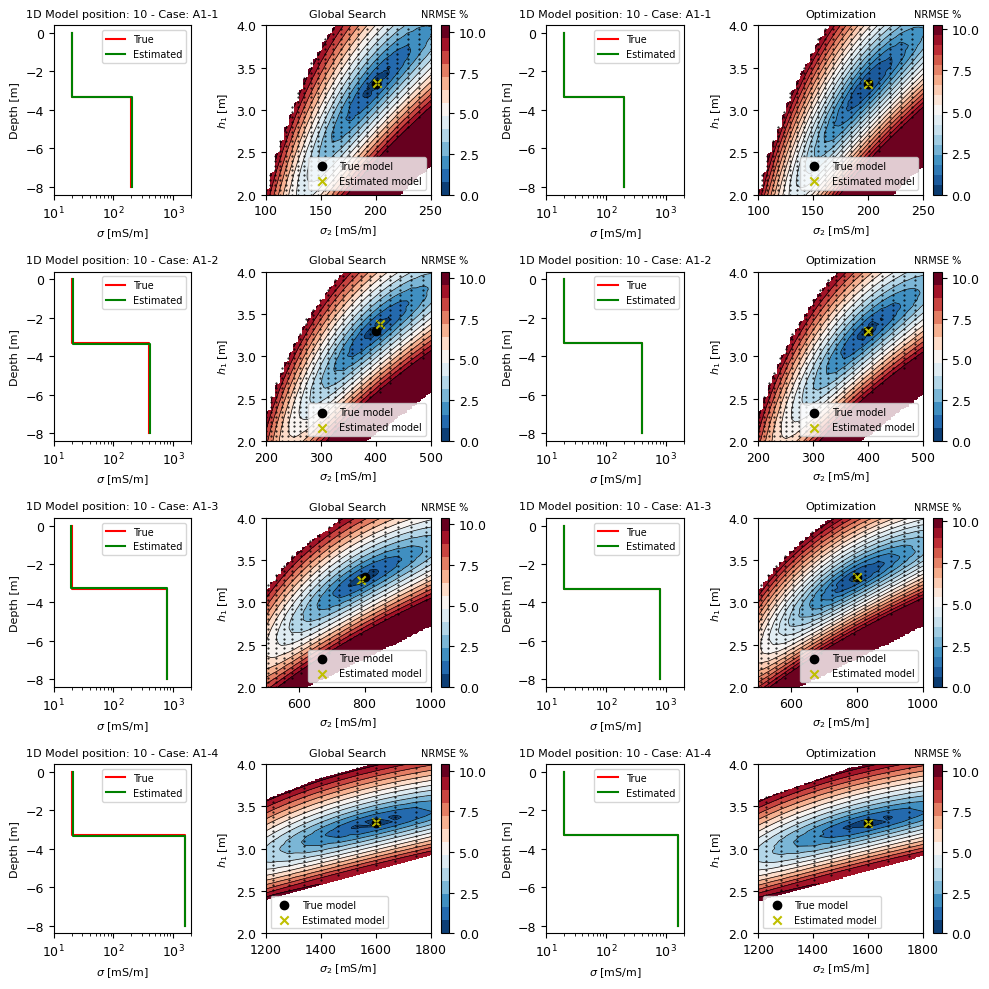

In [64]:
fig, ax = plt.subplots(4,4, figsize=(10,10), gridspec_kw={'width_ratios': [1, 1.5, 1, 1.5]})

PlotErrorSpace(ax[0,0], ax[0,1], model_A1_1[pos], model_GS_A1_1[pos], err_GS_A1_1, models_err_GS_A1_1, 100, 250, 2, 4, 
               case='A1-1', method='Global Search', colorbar=True)
PlotErrorSpace(ax[1,0], ax[1,1], model_A1_2[pos], model_GS_A1_2[pos], err_GS_A1_2, models_err_GS_A1_2, 200, 500, 2, 4,
              case='A1-2', method='Global Search', colorbar=True)
PlotErrorSpace(ax[2,0], ax[2,1], model_A1_3[pos], model_GS_A1_3[pos], err_GS_A1_3, models_err_GS_A1_3, 500, 1000, 2, 4,
              case='A1-3', method='Global Search', colorbar=True)
PlotErrorSpace(ax[3,0], ax[3,1], model_A1_4[pos], model_GS_A1_4[pos], err_GS_A1_4, models_err_GS_A1_4, 1200, 1800, 2, 4,
              case='A1-4', method='Global Search', colorbar=True)

PlotErrorSpace(ax[0,2], ax[0,3], model_A1_1[pos], model_Opt_A1_1[pos], err_Opt_A1_1, models_err_Opt_A1_1, 100, 250, 2, 4, 
              case='A1-1', method='Optimization', colorbar=True)
PlotErrorSpace(ax[1,2], ax[1,3], model_A1_2[pos], model_Opt_A1_2[pos], err_Opt_A1_2, models_err_Opt_A1_2, 200, 500, 2, 4,
              case='A1-2', method='Optimization', colorbar=True)
PlotErrorSpace(ax[2,2], ax[2,3], model_A1_3[pos], model_Opt_A1_3[pos], err_Opt_A1_3, models_err_Opt_A1_3, 500, 1000, 2, 4,
              case='A1-3', method='Optimization', colorbar=True)
PlotErrorSpace(ax[3,2], ax[3,3], model_A1_4[pos], model_Opt_A1_4[pos], err_Opt_A1_4, models_err_Opt_A1_4, 1200, 1800, 2, 4,
              case='A1-4', method='Optimization', colorbar=True)

plt.tight_layout()
#plt.show()
plt.savefig('figures/ErrorSpace_caseA1.eps', format='eps')